<a href="https://colab.research.google.com/github/kayeekim00/kayeekim00.github.io/blob/master/_code_practice/Tensorflow_Time_Series_Prediction_KH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow Core Tutorial 따라하기 (KH Practice)

-. Link. https://www.tensorflow.org/tutorials/structured_data/time_series?hl=ko


이 튜토리얼에서는 TensorFlow를 사용한 시계열 예측을 소개합니다. Convolutional/Recurrent Neural Network(CNN 및 RNN)를 포함하여 몇 가지 다른 스타일의 모델을 빌드합니다.

이 내용은 각각 하위 항목이 있는 두 부분으로 나누어 생각합니다.

- 단일 타임스텝 예측:
    - 단일 특성
    - 모든 특성
- 다중 스텝 예측:
    - 싱글샷: 모두 한 번에 예측합니다.
    - 자가 회귀: 한 번에 하나의 예측을 수행하고 결과를 모델로 피드백합니다.

## Setting

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


## Load Dataset

## 날씨 데이터세트

이 튜토리얼은 <a class="external" href="https://www.bgc-jena.mpg.de/wetter/">막스 플랑크 생물 지구화학 연구소</a>에서 기록한 <a class="external" href="https://www.bgc-jena.mpg.de">날씨 시계열 데이터세트</a>를 사용합니다.

이 데이터세트에는 온도, 대기압 및 습도와 같은 14가지 특성이 있습니다. 이러한 데이터는 2003년부터 시작해 10분 간격으로 수집되었습니다. 효율성을 위해 2009년과 2016년 사이에 수집된 데이터만 사용하겠습니다. 이 데이터세트 부분은 François Chollet이 자신이 저술한 책 [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)을 위해 준비했습니다.

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 0s 0us/step


이 튜토리얼은 **시간별 예측**만 다루므로 10분 간격부터 1시간까지 데이터를 서브 샘플링하는 것으로 시작합니다.

In [4]:
df = pd.read_csv(csv_path)
display(df.head())

# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
display(df.head())
display(date_time.head())

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
Name: Date Time, dtype: datetime64[ns]

df[plot_cols][:480] - 처음 480개의 데이터만 plotting
KH- subplots = True/False 차이 확인하기


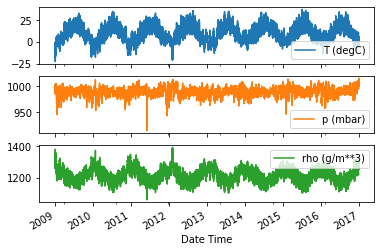

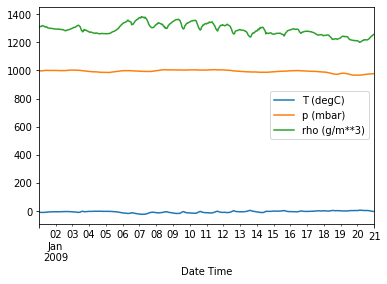

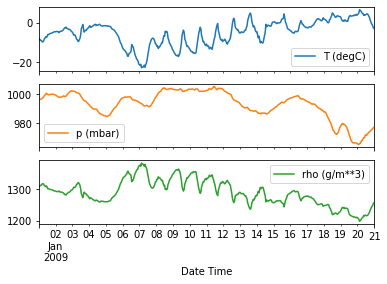

In [12]:
# 시간에 따른 변수 Trend Plotting
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

print('df[plot_cols][:480] - 처음 480개의 데이터만 plotting')
print('KH- subplots = True/False 차이 확인하기')
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots = False)
_ = plot_features.plot(subplots = True)

## EDA & 전처리

## 검사 및 정리하기

*다음으로* 데이터세트의 통계를 살펴봅니다.

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


### 이상치 보정

#### 풍속

한 가지 주목할 점은 풍속의 `min` 값, `wv (m/s)` 및 `max. wv (m/s)` 열입니다. 이 `-9999`는 문제가 있는 것으로 보입니다. 별도의 풍향 열이 있으므로 속도는 `>=0`여야 합니다. 값을 0으로 대체합니다.


In [15]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0 # kh) wv가 -9999.0 이면 true; 조건 값의 소속 여부를 Boolean 값으로 반환
print(bad_wv) # kh) 조건 값의 소속 여부를 Boolean 값으로 반환

wv[bad_wv] = 0.0 # kh) bad_wv = True 인 행 값을 -> 0.0 으로 대체

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0 
max_wv[bad_max_wv] = 0.0

# The above inplacer edits are reflected in the DataFrame
print(df['wv (m/s)'].min())

5         False
11        False
17        False
23        False
29        False
          ...  
420521    False
420527    False
420533    False
420539    False
420545    False
Name: wv (m/s), Length: 70091, dtype: bool
0.0


### 데이터 변환 - 변수화

### 특성 엔지니어링

모델을 본격적으로 빌드하기 전에 데이터를 이해하고 모델에 적절한 형식의 데이터를 전달하는 것이 중요합니다.

#### 바람

데이터의 마지막 열인 `wd (deg)`는 도 단위로 바람의 방향을 나타냅니다. 각도가 있으면 모델 입력으로 좋지 않으므로 360°와 0°는 서로 가까워야 하며 부드럽게 휘어져야 합니다. 바람이 불지 않으면 방향은 중요하지 않습니다.

현재, 바람 데이터의 분포는 다음과 같습니다.

Text(0, 0.5, 'Wind Velocity [m/s]')

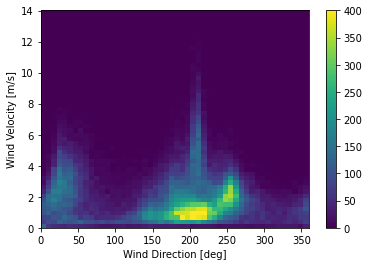

In [16]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

그러나 풍향과 속도 열을 바람 **벡터**로 변환하면 모델이 해석하기가 더 쉽습니다.


In [17]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

바람 벡터의 분포는 모델이 올바르게 해석하기에 훨씬 더 간단합니다.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

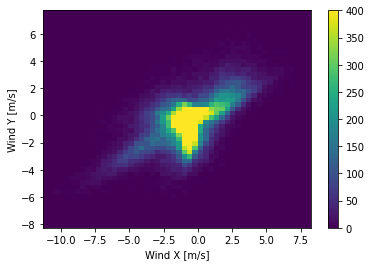

In [18]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### 시간

마찬가지로 `Date Time` 열은 매우 유용하지만 이 문자열 형식으로는 유용하지 않습니다. 우선 초로 변환합니다.

In [21]:
print(datetime.datetime.timestamp) # kh check
print(date_time) # kh check

timestamp_s = date_time.map(datetime.datetime.timestamp)
print(timestamp_s)

<method 'timestamp' of 'datetime.datetime' objects>
5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]
5         1.230772e+09
11        1.230775e+09
17        1.230779e+09
23        1.230782e+09
29        1.230786e+09
              ...     
420521    1.483211e+09
420527    1.483215e+09
420533    1.483219e+09
420539    1.483222e+09
420545    1.483226e+09
Name: Date Time, Length: 70091, dtype: float64


##### 시간 -> 하루 및 연 단위의 주기성 변수로 변환  

풍향과 유사하게 초 단위의 시간은 유용한 모델 입력이 아닙니다. 날씨 데이터이므로 하루 및 연 단위의 주기성이 명확합니다. 주기성을 처리할 수 있는 방법에는 여러 가지가 있습니다.

사용 가능한 신호로 변환하는 간단한 방법은 `sin` 및 `cos`를 사용하여 시간을 명확한 "하루 중 시간" 및 "연중 시간" 신호로 변환하는 것입니다.

In [23]:
day = 24*60*60 # kh) sec -> day: 24hr * 60min * 60sec
year = (365.2425)*day # kh) 통상적으로 사용되는 윤년을 고려한 avg days in year  = 365.2425 

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

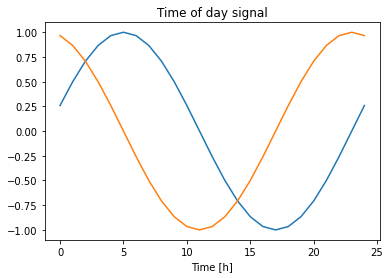

In [24]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

그러면 모델이 가장 중요한 빈도 특성에 액세스할 수 있습니다. 이 경우 어떤 빈도가 중요한지 미리 알고 있었습니다.

모르는 경우 `fft`를 사용하여 중요한 빈도를 결정할 수 있습니다. 시간에 따른 온도의 `tf.signal.rfft`를 보면 여기서 가정한 내용이 확인됩니다. `1/year` 및 `1/day` 근처에서 빈도 피크가 확실하다는 것을 알 수 있습니다. 

kh_check--------
original df['T (degC)'] 
 5    -8.05
11   -8.88
17   -8.81
23   -9.05
29   -9.63
Name: T (degC), dtype: float64
fft 
 [662393.7       +0.j      -4666.83  +37410.137j   -2705.8481+12410.741j
  12935.66   -1294.4241j -16647.074  +6837.21j  ]
f_per_dataset [    0     1     2 ... 35043 35044 35045]
------------


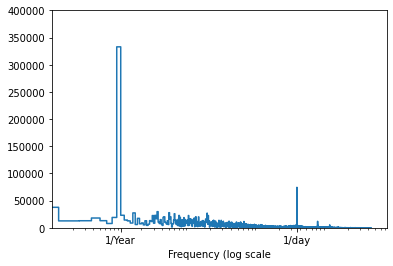

In [35]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

print("kh_check--------")
print(f"original df['T (degC)'] \n {df['T (degC)'].head()}")
print(f"fft \n { fft[0:5] }")
print(f"f_per_dataset {f_per_dataset}")
print("------------")

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day']) # kh) matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs); Get or set the current tick locations and labels of the x-axis.
_ = plt.xlabel('Frequency (log scale')


### 데이터 분할 (train/val/test)

*훈련*, 검증 및 테스트 세트에 `(70%, 20%, 10%)` 분할을 사용합니다. 분할하기 전에 데이터가 임의로 셔플되지 **않습니다**. 이것은 두 가지 이유 때문입니다.

1. 데이터를 연속된 샘플의 창으로 자르는 것이 여전히 가능합니다.
2. 모델을 훈련한 후 수집된 데이터를 바탕으로 평가하므로 검증/테스트 결과가 보다 현실적입니다.

In [38]:
column_indices = {name: i for i, name in enumerate(df.columns)}
print("column_indices", column_indices) # kh check

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print("kh_check -------")
print("length of total dataset", n)
print("length of train_df, val_df, test_df", len(train_df), len(val_df), len(test_df))

column_indices {'p (mbar)': 0, 'T (degC)': 1, 'Tpot (K)': 2, 'Tdew (degC)': 3, 'rh (%)': 4, 'VPmax (mbar)': 5, 'VPact (mbar)': 6, 'VPdef (mbar)': 7, 'sh (g/kg)': 8, 'H2OC (mmol/mol)': 9, 'rho (g/m**3)': 10, 'Wx': 11, 'Wy': 12, 'max Wx': 13, 'max Wy': 14, 'Day sin': 15, 'Day cos': 16, 'Year sin': 17, 'Year cos': 18}
kh_check -------
length of total dataset 70091
length of train_df, val_df, test_df 49063 14018 7010


### 데이터 정규화

신경망을 훈련하기 전에 특성의 크기를 정하는 것이 중요합니다. 정규화는 이 크기 조정을 수행하는 일반적인 방법입니다. 평균을 빼고 각 특성의 표준 편차로 나눕니다.

모델이 검증 및 테스트 세트의 값에 액세스할 수 없도록 훈련 데이터를 사용해서만 평균 및 표준 편차를 계산해야 합니다.

----

또한 모델이 훈련할 때 훈련 세트의 미래 값에 액세스할 수 없어야 하고 이 정규화가 이동 평균을 사용하여 수행되어야 한다고 말할 수도 있습니다. 이 내용은 본 튜토리얼의 중점 사항이 아니며, 검증 및 테스트 세트가 있기 때문에 (다소) 정직한 메트릭을 얻을 수 있습니다. 따라서 단순화를 위해 이 튜토리얼에서는 단순 평균을 사용합니다.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df